Citation:
ChatGPT

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !unzip '/content/gdrive/MyDrive/lfw.zip' -d '/content/gdrive/MyDrive/PR-lfw'

In [ ]:
path = '/content/gdrive/MyDrive/PR-lfw/lfw'

In [ ]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


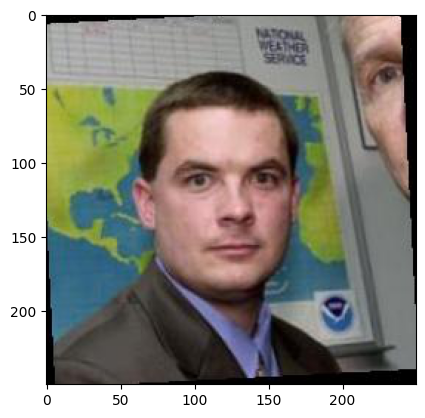

In [ ]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [ ]:
for x, y in dataloader:
    sample_image = x[0]

    print("Sample Image Dimensions:", sample_image.shape)
    channels, height, width = sample_image.shape

    print("Number of Channels:", channels, "(e.g., 3 for RGB)")
    print("Image Height:", height, "pixels")
    print("Image Width:", width, "pixels")

    break

# here, torch.Size([3, 250, 250]) is basically the sample image has three channels, red green and blye and its spatial dimensions are 250 pixels in height
# and width
# Number of Channels: 3 represents the color channels in the image
# Image Height: 250 pixels is the number of pixels along the vertical axis of the image.
# Image Width: 250 pixels is the number of pixels along the horizontal axis of the image.

Sample Image Dimensions: torch.Size([3, 250, 250])
Number of Channels: 3 (e.g., 3 for RGB)
Image Height: 250 pixels
Image Width: 250 pixels


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [ ]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # encoder layers
        self.enc_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
        )

        # decoder layers
        self.dec_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encoder(self, x):
        x = self.enc_layers(x)
        return x

    def decoder(self, x):
        x = self.dec_layers(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x



## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [ ]:
for x, y in dataloader:
    input_image = x[0].unsqueeze(0)
    break

model = AutoEncoder()

encoded_output = model.encoder(input_image)
decoded_output = model.decoder(encoded_output)

print("Input Image Shape:", input_image.shape)
print("Encoded Output Shape:", encoded_output.shape)
print("Decoded Output Shape:", decoded_output.shape)

Input Image Shape: torch.Size([1, 3, 250, 250])
Encoded Output Shape: torch.Size([1, 64, 63, 63])
Decoded Output Shape: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [ ]:
import torch.optim as optim

model = AutoEncoder()

total_params = sum(p.numel() for p in model.parameters())
print("Total Number of Parameters in the Model:", total_params)

loss_function = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# I choose loos function Mean Squared Error. it measures average squared difference between predicted and targeted pixel values. It is usually used in autoencoder models.
# Adam optimizer is used for training model.

Total Number of Parameters in the Model: 38723


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0.0

    for data in dataloader:
        inputs, _ = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_function(outputs, inputs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # initially, I noticed that the loss was not decreasing and it was variably changing. So, I tried changing learning rate.
    #I also added more layers to increase the capacity. Also tried training it on high number of epochs and also changed the batch size.

Epoch [1/10], Loss: 0.0103
Epoch [2/10], Loss: 0.0012
Epoch [3/10], Loss: 0.0009
Epoch [4/10], Loss: 0.0007
Epoch [5/10], Loss: 0.0006
Epoch [6/10], Loss: 0.0005
Epoch [7/10], Loss: 0.0005
Epoch [8/10], Loss: 0.0005
Epoch [9/10], Loss: 0.0004
Epoch [10/10], Loss: 0.0004


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

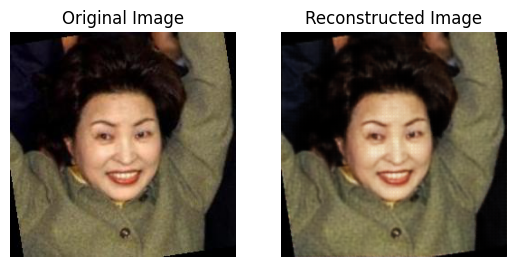

In [ ]:
import random
import matplotlib.pyplot as plt

random_index = random.randint(0, len(dataloader.dataset) - 1)
random_image, _ = dataloader.dataset[random_index]

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(random_image.permute(1, 2, 0))
plt.axis('off')

with torch.no_grad():
    random_image = random_image.unsqueeze(0)
    encoded_output = model.encoder(random_image)
    decoded_output = model.decoder(encoded_output)

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(decoded_output.squeeze().permute(1, 2, 0))
plt.axis('off')

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

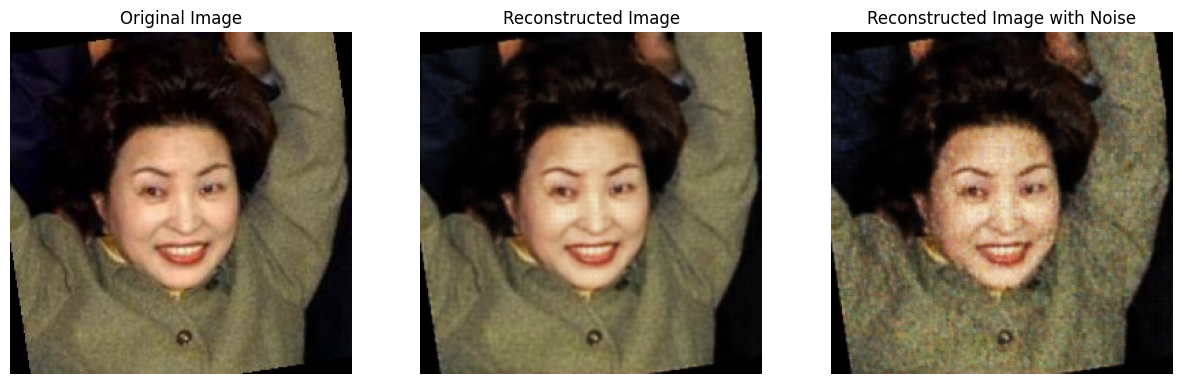

In [ ]:
noise = torch.randn_like(encoded_output) * 0.1
noisy_latent = encoded_output + noise

with torch.no_grad():
    decoded_output_noisy = model.decoder(noisy_latent)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(random_image.squeeze().permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Reconstructed Image")
plt.imshow(decoded_output.squeeze().permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Reconstructed Image with Noise")
plt.imshow(decoded_output_noisy.squeeze().permute(1, 2, 0))
plt.axis('off')

plt.show()

# per my observation, adding noise helped me in determining robustness of the model, it introduced some disturbances and blurryness to the information encoded in the latent representation.
# All in all, I was able to determine that even after the noise, the image is still recognizable and it still retains the important features of the original image.